# Модуляция с остаточной боковой полосой
# Vestigial Side Band
# (VSB)

## 1. Введение

Вид амплитудной модуляции, который является промежуточным вариантом между DSB и SSB и сочетает их преимущества и недостатки, называется модуляцией с остаточной боковой полосой (Vestigial Side Band - VSB). В данном методе одна из половин спектра сигнала удаляется не полностью, как в SSB, а лишь частично. Полоса сигнала при этом будет больше, чем у однополосного сигнала, но меньше чем у DSB. 


## 2. Модулятор VSB сигнала

Чтобы сформировать VSB сигнал, необходимо удалить часть спектральных компонент у одной из половин спектра. Это можно сделать на несущей частоте с помощью полосового фильтра, или на нулевой частоте с помощью фильтра нижних частот. Последний вариант более предпочтителен. Этот способ ни чем не отличается от "третьего метода" для SSB модуляции.

Спектр действительного информационного ссобщения симметричен относительно нулевой частоты. Этот спектр можно подвинуть по частоте с помощью умножения на комплексную экспоненту. Сигнала при этом также станет комплексным. Если теперь подать этот сигнал на фильтр, полоса которого больше половины полосы спектра, но меньше, чем вся полоса сигнала, то мы получим VSB сигнал. Если в частотной области сигнал был сдвинут в сторону отрицательных частот, то будет обрезана нижняя половина спектра. Этот сигнала можно назвать USB VSB. Если сдвигать в область положительных частот, то обрежется верхняя половина, и мы получим LSB VSB.

После фильтрации сигнал умножается на несущую и передается в эфир. В этом случае, сигнал не будет в явном виде содержать гармонику на частоте несущей, поэтому такой сигнал называют VSB-SC. Если до первого сдвига спектра к сообщению добавить постоянную составляющую, то получим VSB-TC. 

Схема передающего устройства совпадает со схемой, представленной в SSB Transmitter:

<img src="../../images/VSB_1.png" width=450/>

Ниже представлен скрипт для получения VSB сигнала при модуляции аудиосообщением. С помощью переменной ModulationMethod можно выбрать, какой сигнал будет сформирован: USB или LSB. Переменная Ас задает амплитуду несущей. Еcли она равна нулю, то мы получим VSB-SC, иначе VSB-TC. Будем считать, что полоса исходного сообщения равна 22 kHz, и требуется, чтобы полоса VSB синала была равна 30 kHz. Таким образом, перед фильтрацией спектр сообщения нужно подвинуть на 22 - (30/2) = 6 kHz.  

Чтобы переместить сигнал на частоту несущей, после низкочастотной фильтрации его дополнительно необходимо сдвинуть обратно на 6 kHz. Это можно сделать сразу во время переноса на несущую, умножая сигнал на комплексную экспоненту, частота которой равна сумме частоты несущей и частоты сдвига.

Скрипт выполняющий, описанные преобразования, представлен ниже:

<IPython.core.display.Javascript object>


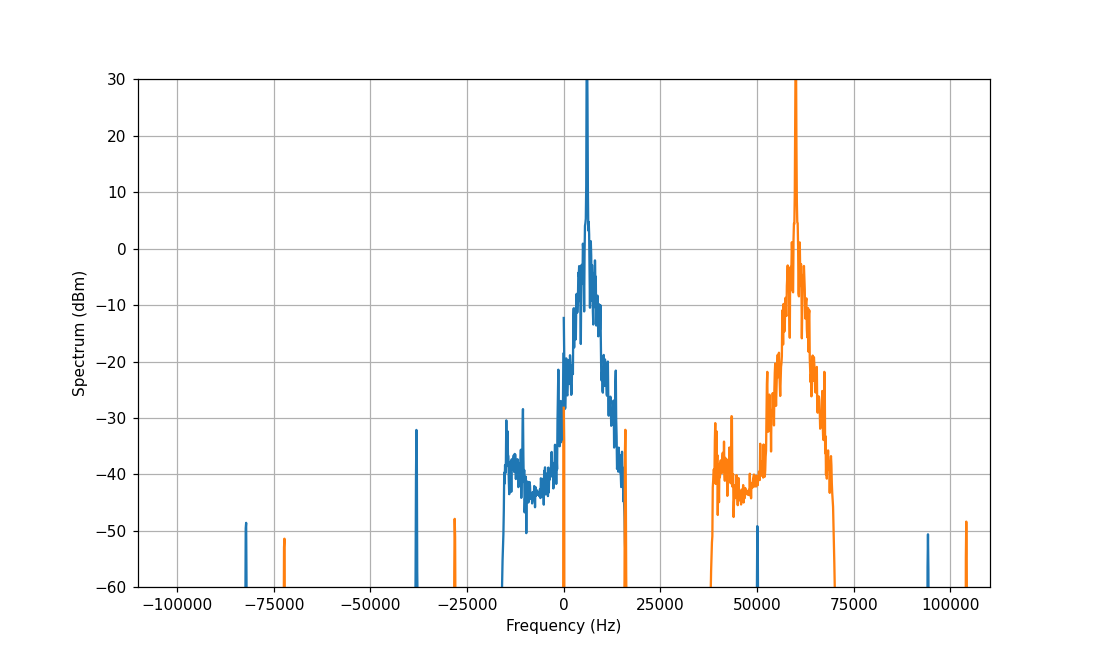

In [1]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import time, wave, sounddevice

from scipy.signal import welch, resample_poly, firls, lfilter

audio_frame_size = 1000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 300      # число обрабатываемых пачек данных
rate_ratio = 5           # коэффициент увеличения частоты дискретизации
Ac = 2                   # амплитуда несущей 

modulation_method = "LSB"  # USB или LSB

# открываем файл и получаем частоту дискретизации
audio_file = wave.open('../../wav/Audio_Source.wav')
audio_fs = audio_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
signal_fs = audio_fs * rate_ratio
signal_frame_size = audio_frame_size * rate_ratio

# получение коэффициентов ФНЧ
H = firls(75, (0, 15e3, 16e3, audio_fs/2), (1, 1, 0, 0), fs=audio_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-60, 30)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

vsb_am_signal_array = np.zeros((frames_number, signal_frame_size), dtype=complex)

# отсчеты времени
t_s = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 
t_a = np.linspace(0, audio_frame_size/audio_fs, audio_frame_size) 

FIR_tap_values = np.zeros(len(H) - 1) # внутреннее состояние ФНЧ

# запуск симуляции
for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    audio_data = audio_file.readframes(audio_frame_size)    # считываем отсчеты
    audio_data = np.frombuffer(audio_data, dtype=np.int16)  # преобразуем тип данных из byte в int16
    audio_data = np.reshape(audio_data, (-1, 2))            # разделяем отсчеты для правого и левого канала
    audio_data = audio_data / 2**15                         # нормируем отсчеты к единице
    
    # добавление постоянной составляющей
    audio_data[:,0] = audio_data[:,0] + Ac

    # комплексный сигнал для смещения по частоте
    # частота сигнала: 6 kHz
    mixer_carrier = np.exp(1j * 2 * np.pi * 6e3 * t_a)
    
    # перенос по частоте и фильтрация для удаления второй полосы
    if modulation_method == "LSB":
        mixed_data = audio_data[:,0] * mixer_carrier
    else:
        mixed_data = audio_data[:,0] * np.conj(mixer_carrier)
    
    filtered_data, FIR_tap_values = lfilter(H, 1.0, mixed_data, zi=FIR_tap_values)
    
    # увеличиваем частоту дискретизации
    upsampled_data = resample_poly(filtered_data, rate_ratio, 1)
    
    # комплексный несущий сигнал
    # частота несущей: 60 kHz
    if modulation_method == "LSB":
        carrier = np.exp(1j * 2 * np.pi * (60e3 - 6e3) * t_s)
    else:
        carrier = np.exp(1j * 2 * np.pi * (60e3 + 6e3) * t_s)
        
    # перенос на частоту несущей
    vsb_am_signal = upsampled_data * carrier    
    vsb_am_signal_array[frame,:] = vsb_am_signal
    
    # посторение спектрограмм
    signals = upsampled_data, vsb_am_signal
    
    for i in range(2):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=2048) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                           # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t_s = t_s + signal_frame_size/signal_fs 
    t_a = t_a + audio_frame_size/audio_fs 


Синим цветом на графике представлен спектр сообщения после низкочастотной фильтрации, а оранжевым - спектр модулированного сигнала. Можно увидеть, одна из половин спектра обрезана, и полоса сигнала равна 30 kHz.


## 3. Когерентная демодуляция VSB сигнала

Так как VSB сигнал является промежуточным вариантом между SSB и DSB, то его можно принимать когерентно с помощью умножения на колебание, частота и фаза которого совпадает с несущей. Схема приемника представлена ниже:

<img src="../../images/VSB_2.png" width=450/>

Скрипт, выполняющий демодулцию представлен ниже. С помощью переменных freq_offset и phase_offset можно задать расстройку по частоте и фазе и на слух оценить искажения сигнала. Перед запуском скрипта необходимо выполнить скрипт из параграфа 2.

<IPython.core.display.Javascript object>


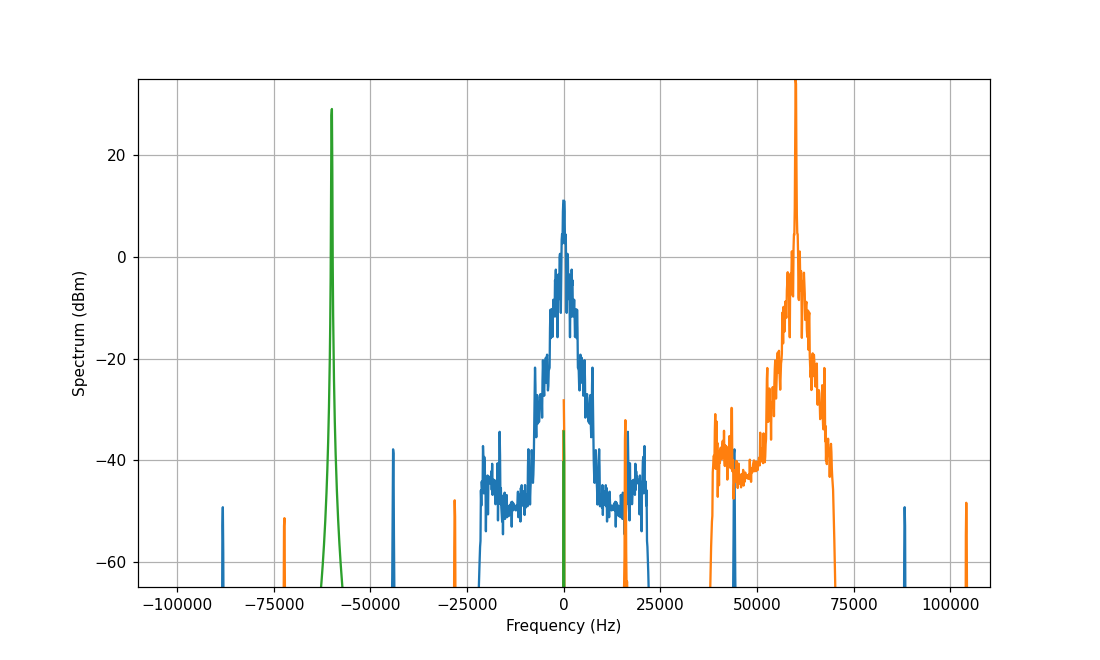

In [2]:
audio_amp = 0.1               # коэффициент усиления аудиосигнала
freq_offset = 0               # расстройка по частоте (Hz)
phase_offset = 0 * np.pi/180  # расстройка по фазе (градусы)


# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-65, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

message = []

for frame in range(frames_number):

    # получение отсчетов сигнала
    vsb_am_signal = vsb_am_signal_array[frame,:]

    # формируем несущую с возможными ошибками
    demod_carrier = np.exp(-1j * 2 * np.pi * (60e3 + freq_offset) * t + phase_offset)
    
    # смешивание АМ-сигнала и несущей и выделение действительной части
    baseband_signal = np.real(vsb_am_signal * demod_carrier)
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = baseband_signal, vsb_am_signal, demod_carrier
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=2048) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 
    
sounddevice.play(message * audio_amp, audio_fs, blocking=True)

На графике оранжевым цветом представлен VSB сигнал, зеленым - гармоническое колебание в приемнике, синим - восстановленное сообщение. 

На слух можно оценить, что искажения из за расстройки и частоте или фазе аналогичны, тем что были получены для DSB и SSB сигналов.

Стоит ответить следующий момент. При переносе на нулевую частоту, компоненты из обрезанной половины спектра будут накладывать на компоненты из другой половины и усиливать их. Таким образом, одна часть спектра сообщения будет получать большее усиление, чем другая. Для нашего примера, сигнал имеет полосу в 30 kHz, при этом 22 kHz - это одна половина, и 8 kHz - это вторая обрезанная часть. При наложении спектральных компонент из разных частей, область частот от 0 до 8 kHz получит большее усиление, чем область от 8 до 22 kHz. Для нашего примера это не вызывает никаких искажений, но если это необходимо эту разность в усилениях можно убрать с помощью фильтра, с правильно подобранной АЧХ.


## 4. Удаление остаточной части спектра при демодуляции VSB

Помимо применения выравнивающего фильтра, АЧХ которого подобрана таким образм, чтобы компенсировать отличия в усилении разных частей спектра, можно воспользоваться методом разделения каналов, который рассматривался в SSB SC Receiver Part 2. 

После переноса на нулевую частоту, но перед выделением действительной части, VSB сигнал можно дополнительно отфильтровать, чтобы удалить компоненты спектра из образанной половины.

Ниже представлен скрипт, выполняющий описанные преобразования. Перед запуском скрипта необходимо выполнить скрипт из параграфа 2.

<IPython.core.display.Javascript object>


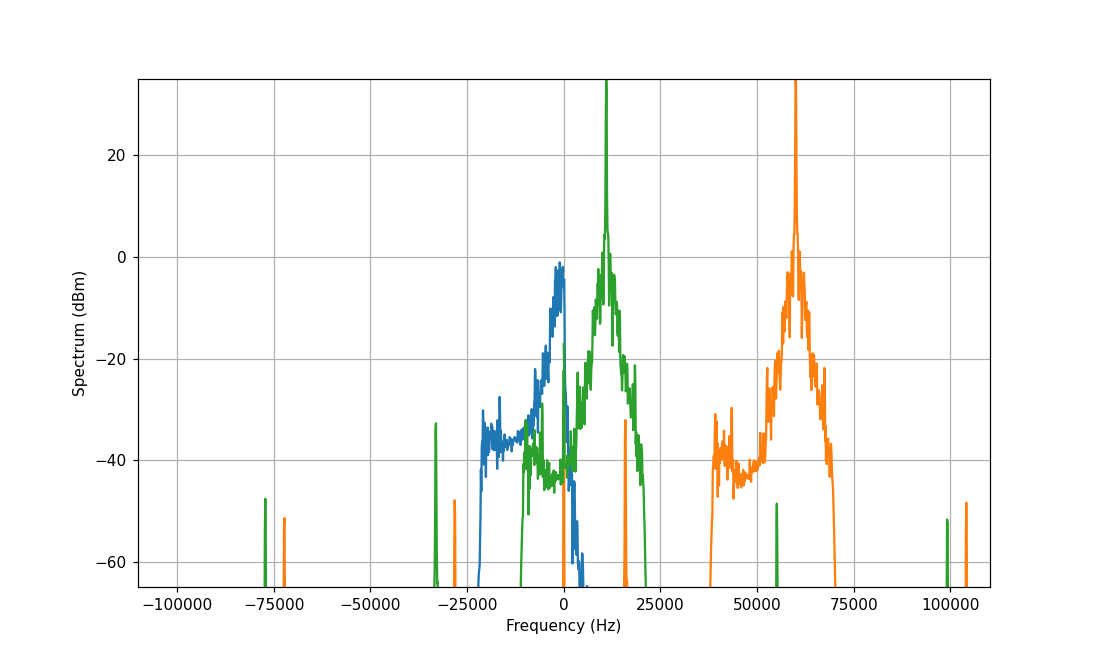

In [3]:
# получение коэффициентов ФНЧ
H = firls(205, (0, 10e3, 11e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-65, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

FIR_tap_values = np.zeros(len(H) - 1) # внутреннее состояние ФНЧ

for frame in range(frames_number):

    # получение отсчетов сигнала
    vsb_am_signal = vsb_am_signal_array[frame,:]

    # формируем несущую с возможными ошибками
    if modulation_method == "LSB":
        demod_carrier = np.exp(-1j * 2 * np.pi * (60e3 - 11e3) * t)
    else:
        demod_carrier = np.exp(-1j * 2 * np.pi * (60e3 + 11e3) * t)
    
    # смешивание АМ-сигнала и несущей и выделение действительной части
    mixed_signal = vsb_am_signal * demod_carrier
    
    # низкочастотная фильтрация
    filtered_signal, FIR_tap_values = lfilter(H, 1.0, mixed_signal, zi=FIR_tap_values)
    
    # получения комплексной экспоненты для компенсации сдвига по частоте
    if modulation_method == "LSB":
        shift_carrier = np.exp(-1j * 2 * np.pi * 11e3 * t)
    else:
        shift_carrier = np.exp(1j * 2 * np.pi * 11e3 * t)
        
    # компенсация сдвига по частоте
    baseband_signal = filtered_signal * shift_carrier
    
    # построение спектрограмм
    signals = baseband_signal, vsb_am_signal, mixed_signal
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=2048) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

На спектрограмме показан исходный VSB сигнал (оранжевый). Зеленым показан сдвинутый по частоте принятый сигнал. Сдвиг выполняется таким образом, чтобы середина нужной половины спектра располагалась на нулевой частоте. Далее применяется фильтр нижних частот и все спектральные компоненты кроме нужной половины спектра удаляются. В завершении отфильтрованный сигнал сдвигается на нулевую частоту (синий).

## 5. Некогерентная демодуляция

Так как VSB сигнала совмещает в себе свойства DSB и SSB, то при определенных условиях его можно принимать некогерентно. В SSB TC Receiver было отмечено, что для случая DSB TC, чтобы использовать некогерентный метод приема необходимо выполнение условия ${\mathrm{A}}_c \ge \max \left\lbrace m\left(t\right)\right\rbrace$.  Для SSB TC требования более жесткие: ${\mathrm{A}}_c >>\max \left\lbrace m\left(t\right)\right\rbrace$. То есть, амплитуда несущей должна быть много больше максимального значения сообщения. 

Для VSB сигнала так же можно применять некогерентный приемник при условии ${\mathrm{A}}_c >>\max \left\lbrace m\left(t\right)\right\rbrace$. Однако, качество восстановленного сообщения при увеличении амплитуды несущей улучшается быстрее, чем для SSB.

Для получаения огибающей комплексного сигнала достаточно вычислить его модуль. Воспользуемся тем же скриптом, который рассмотривается в DSB TC Receiver Part 3. Скрипт представлен ниже. Перед запуском скрипта необходимо выполнить скрипт из параграфа 2, помощью переменной Ас которого можно изменять амплитуду несущей. 

<IPython.core.display.Javascript object>


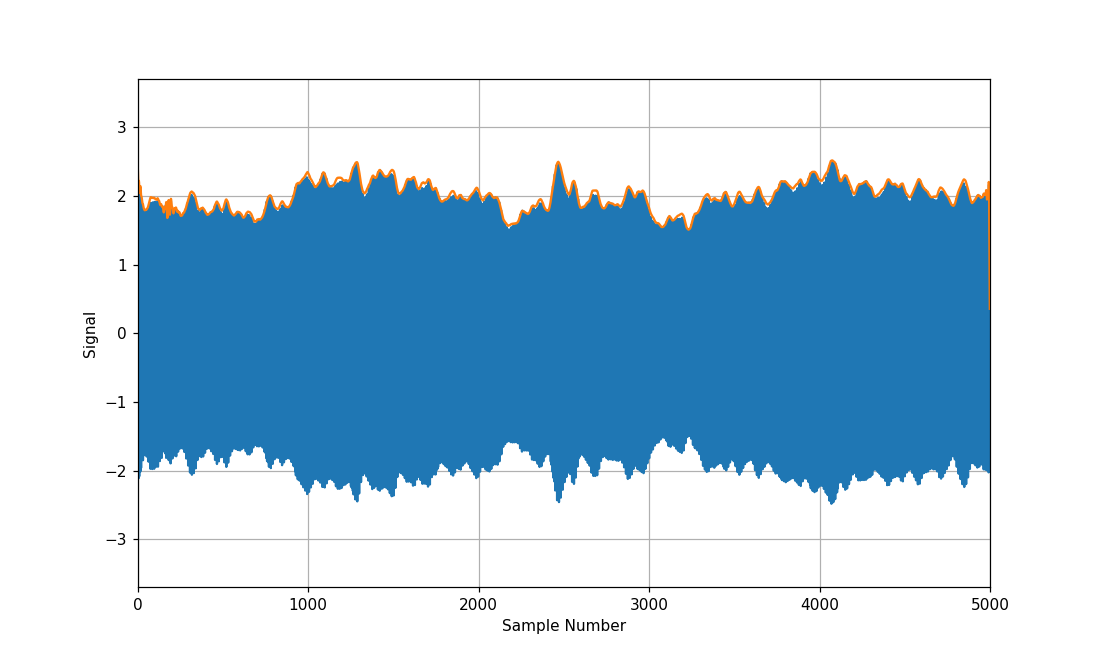

In [2]:
audio_amp = 0.1               # коэффициент усиления аудиосигнала

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Sample Number')
ax.set_ylabel('Signal')
ax.set_xlim(0, signal_frame_size)
ax.set_ylim(-3.7, 3.7)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

message = []

for frame in range(frames_number):

    # получение отсчетов сигнала
    vsb_am_signal = vsb_am_signal_array[frame,:]

    # вычисление модуля сигнала для амплитудной детекции
    baseband_signal = np.abs(vsb_am_signal)
    
    # построение временных диаграмм
    ax.lines[0].set_ydata(np.real(vsb_am_signal))
    ax.lines[1].set_ydata(baseband_signal)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_signal = baseband_signal - baseband_signal.mean()
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 
    
sounddevice.play(message * audio_amp, audio_fs, blocking=True)

## 8. Преимущества и недостатки SSB-TC
Преимущества:
- уменьшение вдвое ширины спектра модулированного сигнала;
- возможно применение обычной PLL для когерентного приема;
- при определенных условиях можно использовать некогерентный приемник.

Недостатки:
- модуляция менее эффективна с точки зрения мощности, так как несущая передается.

## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR